In [1]:
import matplotlib.pyplot as plt
import scipy.stats as st
import seaborn as sns
import torch.nn as nn
import pandas as pd
import numpy as np

import itertools
import torch

from torch.utils.data import DataLoader, TensorDataset, Dataset
from copy import deepcopy

In [2]:
def generate_plot(src_path='x_test_sample.csv', img_path='sample1.png'):
    data = pd.read_csv(src_path)
    display(data.head())
    plt.figure(figsize=(16,4), dpi=200)
    sns.lineplot(x=np.linspace(0,data.shape[1],data.shape[1]), y=data.iloc[0,:])
    plt.ylim([0,1])
    plt.savefig(img_path, dpi=200)
    plt.show()
    return

# Goal
Build a neural network that can accurately estimate parameters of a sine function, even when noise is added. Data can then be used to pretrain a network working with sinusoidal type data.

# Variations in Synthetic Data
- **Sine Wave**:  
    - `period` : period of each sign wave, target variable  
    - `amplitude` : amplitude associated with the sine wave  
    - `phase` : where the sine wave starts horizontally
    - `offset` : y location of the sine wave
- **Noise**:
    - `noise distribution` : generating distribution for the noise added to the wave
    - `noise magnitude` : magnitude of noise added to the sine wave
    - `noise method` : multiplicative or additive noise
- **Additional**:
    - `padding` : how values are padded, primarily concerning if sine waves are repeated for multiple periods or only a single period with padding values
    - `slant` : 
    

# Eventual Supervision Labels

- Sine/Flat : int
- Sine/Flat/Noisy : int
- % Sine vs Flat : float
- Denoised : array_like
- Period/Parameters : float/array_like
- Sine Indices : array_like

## Constants

In [3]:
SINE_LEN = 251
N_EPOCHS = 200
NOISE_SAMPLES = 12

## Noise Generation

In [4]:
def add_noise(arr, distribution='gaussian', symmetric=True, noise_amplitude=1, method='additive', bias=0):
    noise_len = len(arr)
    match distribution:
        case 'gaussian':
            dist = st.norm(0,.5)
        case 'beta':
            dist = st.beta(0,1)
        case 'levy':
            dist = st.levy(0,1)
        case 'uniform':
            dist = st.uniform(0,1)
        case 'pareto':
            dist = st.power(0,1)
        case 't':
            dist = st.t(4,0,1)
    noise_arr = dist.rvs(size=noise_len)
    if bias:
        noise_arr = np.add(noise_arr, bias)
    if symmetric and distribution in ['beta','pareto']:
        random_indices = np.random.randint(0,1).astype(bool)
        noise_arr[random_indices] = -noise_arr[random_indices]
    if method == 'additive':
        arr = np.add(arr, noise_arr)
    elif method == 'multiplicative':
        arr = np.multiply(arr, noise_arr)
    else:
        raise ValueError(f'{method} not recognized as noise method')
    return arr

## Sine Wave Generation

In [5]:
def return_copy(func):
    def wrapper(*args, **kwargs):
        output = func(*args, **kwargs)
        return deepcopy(output)
    return wrapper

def recursive_copy(func):
    def wrapper(*args, **kwargs):
        instances = list()
        filt_iter = lambda x : isinstance(x[1], (list, np.ndarray))
        prev = None
        for key, vals in filter(filt_iter, kwargs.items()):
            for val in vals:
                func_kwargs = deepcopy(kwargs) # dictionary method for this?
                func_kwargs[key] = val
                output = func(*args, prev=prev, **func_kwargs)
                prev = deepcopy(output)
                instances.append(prev)
        return instances
    return wrapper

class WaveGen():
    def __init__(self, size=100, sample_level='total', prev=None):
        self.size = size
        self.sample_level = sample_level
        self.prev = prev
        
        self.x = None
        self.wave = None
        
        self._bias = 0
        self._amp = 1
        
        self.indices = None
        return
    
    def linear_phase(self, phase_angle=0, n_periods=5):
        self.x = np.linspace(phase_angle, n_periods * np.pi * 2 + phase_angle, self.size)
        return self
    
    def geometric_phase(self, phase_angle=0, n_periods=0):
        # Test if this is ever useful
        self.x = np.geomspace(phase_angle, n_periods * np.pi * 2 + phase_angle, self.size)
        return self
   
    def cos(self):
        if self.x is None:
            self = self.linear_phase()
        self.wave = np.cos(self.x)
        return self
    
    def _ensure_sin(self):
        if self.x is None:
            self = self.linear_phase()
        if self.wave is None:
            self = self.sin()
        return self
    
    def sin(self):
        # won't be meaningful until adjustments to x are made
        if self.x is None:
            self = self.linear_phase()
        self.wave = np.sin(self.x)
        return self
        
    def bias(self, bias=0):
        self._bias = bias
        return self
    
    def amp(self, amp=1):
        self._amp = amp
        return self
    
    def _assemble(self):
        self = self._ensure_sin()
        self.wave *= self._amp
        self.wave += self._bias
        return self
    
    def pad(self, left_pad=0, right_pad=0):    
        self.left_pad = left_pad
        self.right_pad = right_pad
        return self
    
    def noise_patch(self, start=0, stop=-1, **noise_kwargs):
        raise NotImplementedError
        return self
    
    def gaussian_noise(self, indices=None, loc=0, std=1):
        if self.indices is None:
            self.indices = np.linspace(0, self.size-1, self.size).astype(np.int32) if indices is None else indices
        elif indices is not None:
            print('Overriding indices')
            self.indices = indices
        self.noise = lambda n_samples : np.random.normal(loc, std, size=(n_samples, len(indices)))
        return self
    
    def t_noise(self, indices=None, loc=0, std=1, dof=1):
        if self.indices is None:
            self.indices = np.linspace(0, self.size-1, self.size).astype(np.int32) if indices is None else indices
        elif indices is not None:
            print('Overriding indices')
            self.indices = indices
        self.noise = lambda n_samples : np.random.standard_t(dof, size=(n_samples, len(self.indices))) * std + loc
        return self
    
    def sample(self, n_samples=1000):
        self = self._assemble()
        if self.indices is None: 
            print('Entered')
            self.indices = np.linspace(0, self.size-1, self.size).astype(np.int32)
        wave = np.expand_dims(self.wave, axis=0) # broadcast
        background = np.zeros((n_samples, wave.shape[1]), dtype=np.float32)
        background[:,self.indices] = self.noise(n_samples) 
        samples = wave + background
        return samples

large_wave_gen = WaveGen(size=1_000).linear_phase().cos().amp(.5).t_noise(std=.01, dof=5)
small_wave_gen = WaveGen(size=1_000).linear_phase().cos().amp(.05).t_noise(std=.01, dof=5)
flat_wave_gen = WaveGen(size=1_000).linear_phase().cos().amp(.005).t_noise(std=.01, dof=5)

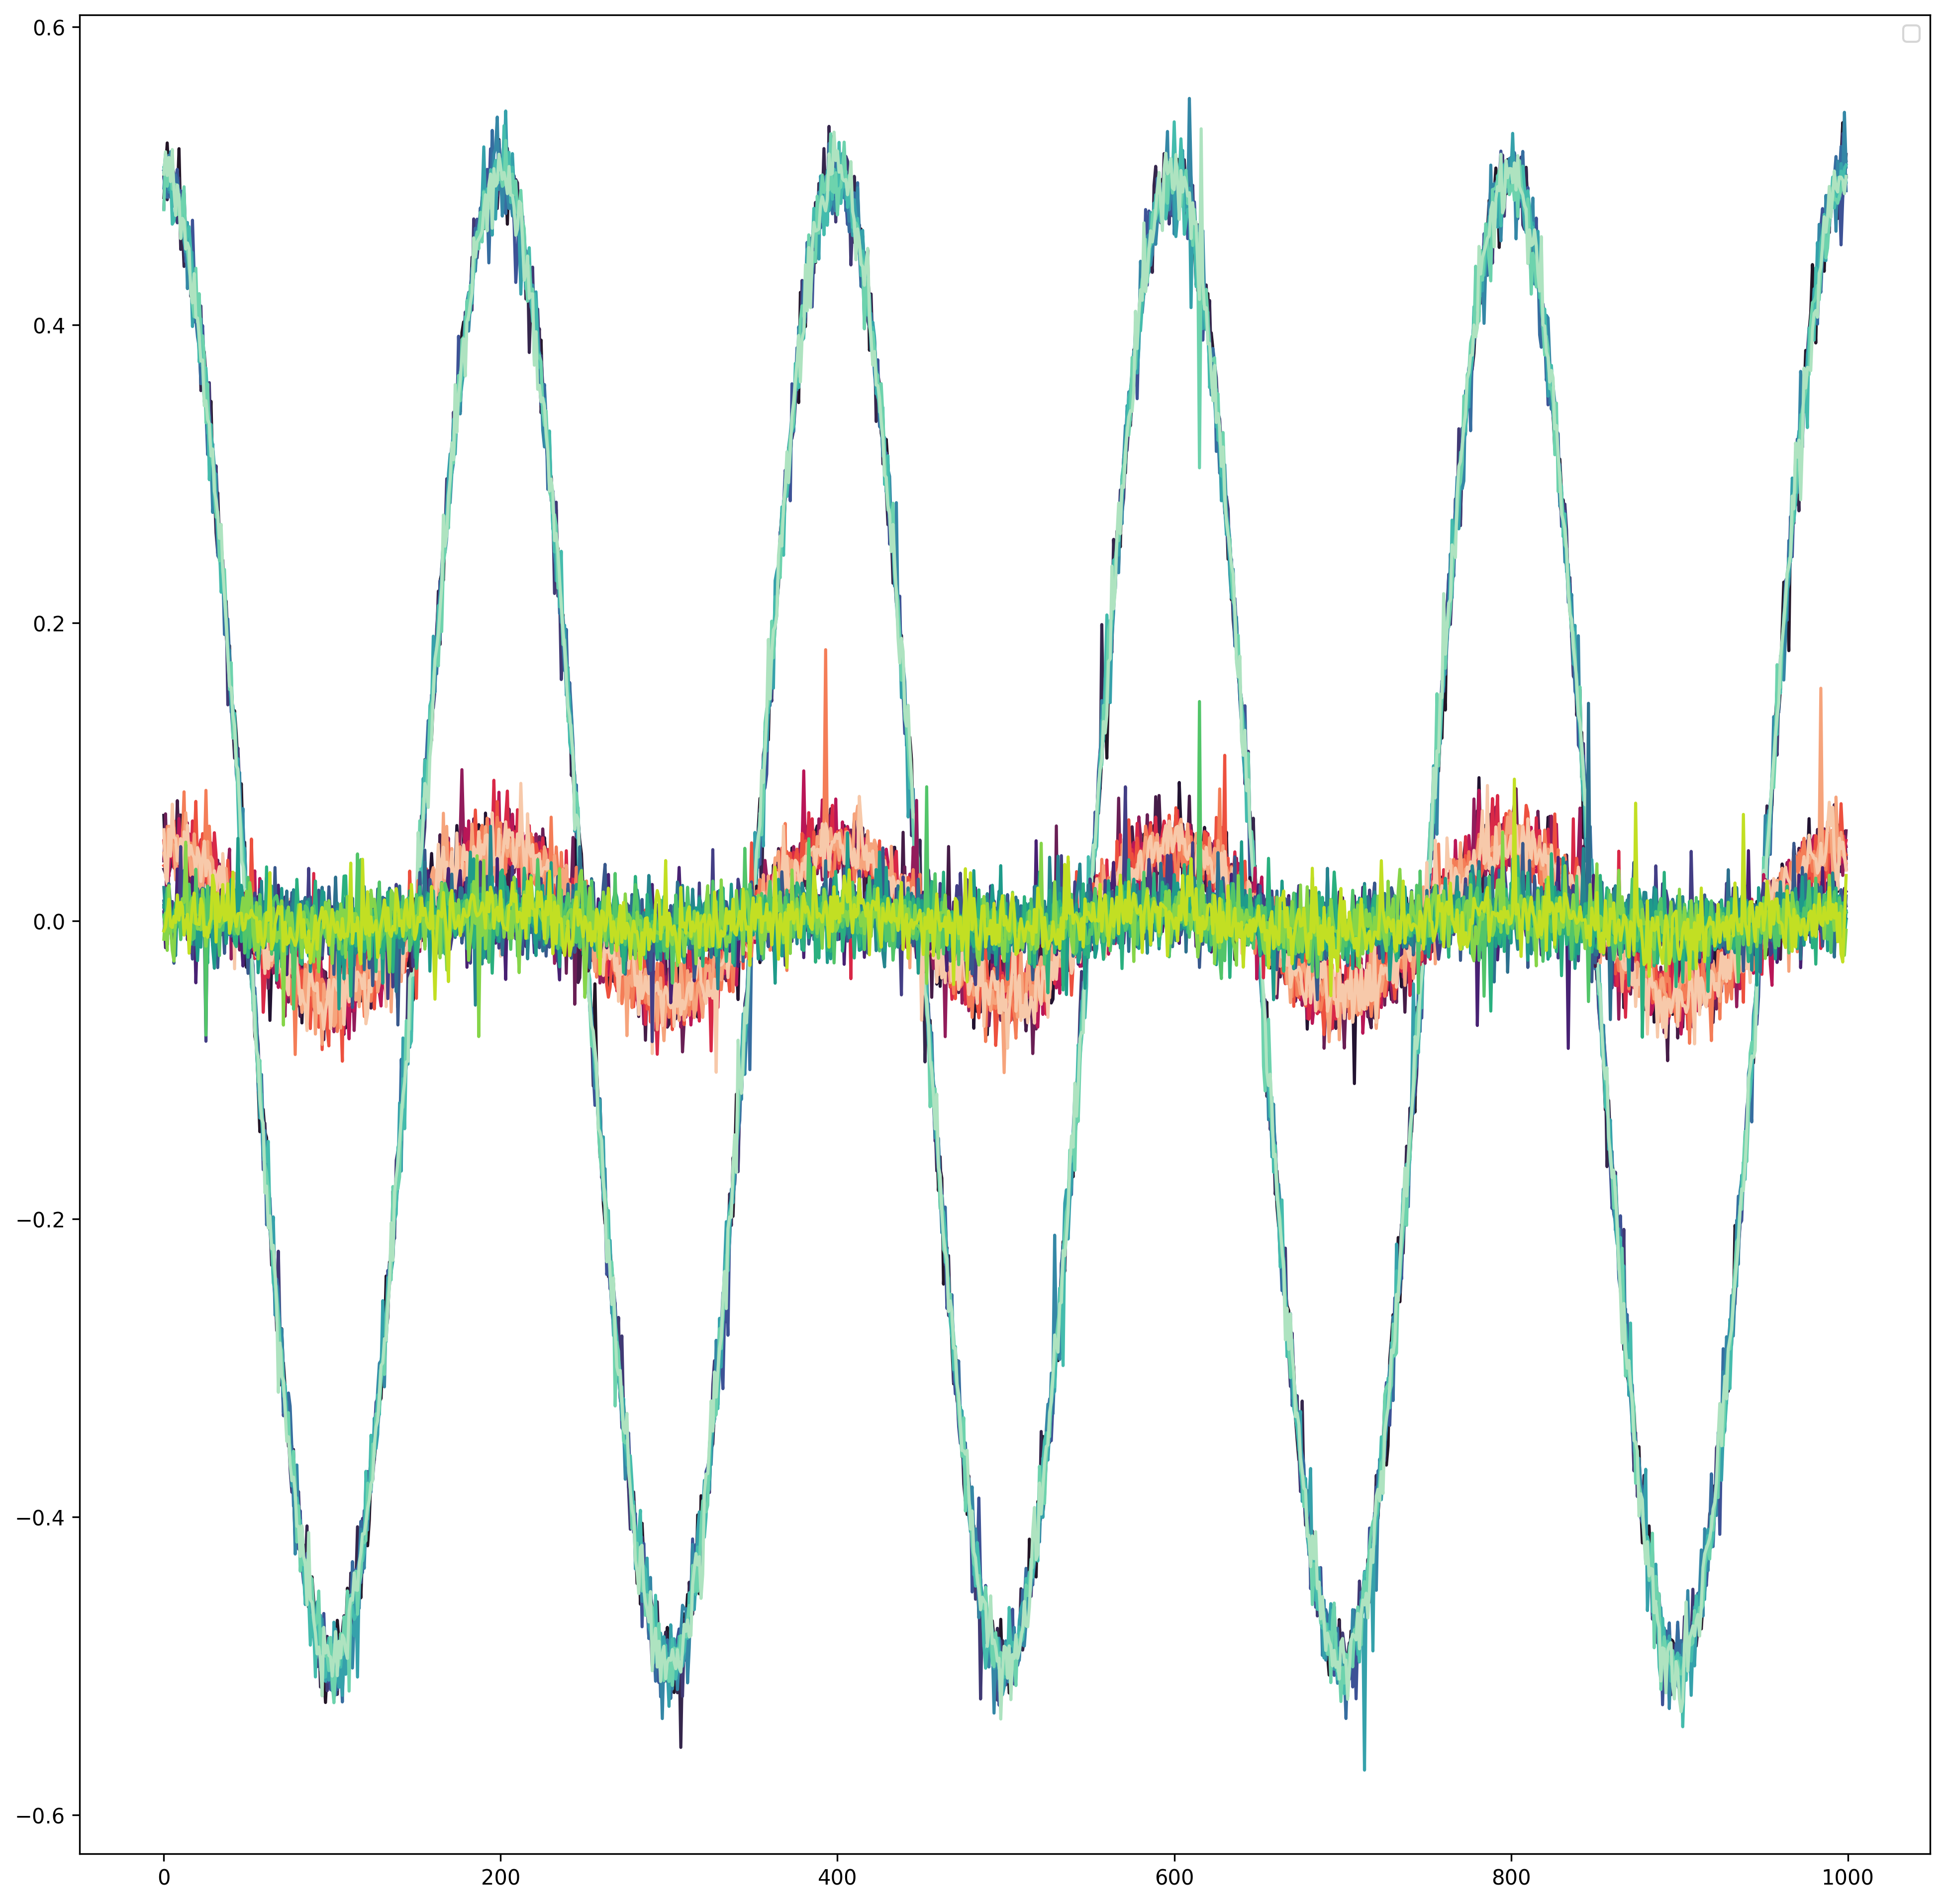

In [6]:
plt.figure(figsize=(16,16), dpi=300)
sns.lineplot(data=large_wave_gen.sample(10).T, palette='mako', dashes=False)
sns.lineplot(data=small_wave_gen.sample(10).T, palette='rocket', dashes=False)
sns.lineplot(data=flat_wave_gen.sample(10).T, palette='viridis', dashes=False)
plt.legend([])
plt.show()

In [7]:
def torch_train_test_split(*tensors, split=.8):
    n_samples = tensors[0].shape[0]
    train_size = int(split * n_samples)
    test_size = n_samples - train_size
    rand_indices = torch.randperm(n_samples)
    train_indices, test_indices = torch.split(rand_indices, [train_size, test_size])
    assert train_indices.shape[0] == train_size, f'{train_indices.shape} != {train_size}'
    assert test_indices.shape[0] == n_samples - train_size, f'{test_indices.shape} != {n_samples - train_size}'

    data_tensors = list()
    for tensor in tensors:
        assert tensor.shape[0] == n_samples
        train_data = tensor[train_indices]
        test_data = tensor[test_indices]
        data_tensors.extend((train_data, test_data))
    return data_tensors

def torch_data_from_dict(dataset_dict, separate=True):
    tensors = list()
    for label, arr in dataset_dict.items():
        # convert this from arr to tensor after numpy change
        dataset_samples = arr.shape[0]
        input_tensor = torch.from_numpy(arr)
        label_tensor = torch.full((dataset_samples, ), label)
        display(input_tensor.shape)
        display(label_tensor.shape)
        if separate:
            tensors.append((input_tensor, label_tensor))
        else:
            tensor = torch.cat([input_tensor, label_tensor], dim=1)
            tensors.append(tensor)
            
    if separate:
        input_tensors, label_tensors = zip(*tensors)
        input_tensor = torch.cat(input_tensors, dim=0).unsqueeze(axis=1).double()
        label_tensor = torch.cat(label_tensors, dim=0).double()
        display(input_tensor.shape)
        display(label_tensor.shape)
        return input_tensor, label_tensor
    else:
        tensor = torch.cat(tensors, dim=0).double()
        return tensor
    
class TorchDataset(Dataset):
    def __init__(self, input_tensor, label_tensor):
        assert input_tensor.shape[0] == label_tensor.shape[0], f'{input_tensor.shape} != {label_tensor.shape[0]}'
        self._data = input_tensor
        self._label = label_tensor
        return
    
    @property
    def shape(self):
        return self._data.shape

    def __len__(self):
        return self._data.shape[0]

    def __getitem__(self, index):
        data = self._data[index]
        label = self._label[index]
        return data, label

In [8]:
dataset_samples = 10_000

dataset_dict = {
    1. : large_wave_gen.sample(dataset_samples),
    .5 : small_wave_gen.sample(dataset_samples),
    0. : flat_wave_gen.sample(dataset_samples),
}

In [9]:
data, labels = torch_data_from_dict(dataset_dict)
train_data, test_data, train_labels, test_labels = torch_train_test_split(data, labels, split=.9)

train_dataset = TorchDataset(train_data, train_labels)
test_dataset = TorchDataset(test_data, test_labels)

torch.Size([10000, 1000])

torch.Size([10000])

torch.Size([10000, 1000])

torch.Size([10000])

torch.Size([10000, 1000])

torch.Size([10000])

torch.Size([30000, 1, 1000])

torch.Size([30000])

In [10]:
class SineCNN(nn.Module):
    def __init__(
        self, 
        input_size, 
        out_channels=16, 
        kernel_size=2, 
        stride=4, 
        pool_kernel=4, 
        drop=.4, 
        dense_size=32
    ):
        super(SineCNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=out_channels, kernel_size=kernel_size, stride=stride)
        conv1_out_shape = (input_size - kernel_size) // stride + 1
        self.activation = nn.LeakyReLU(negative_slope=.2)
        self.maxpool = nn.MaxPool1d(kernel_size=pool_kernel)
        pool_out_shape = (conv1_out_shape - pool_kernel) // pool_kernel + 1
        self.fc1 = nn.Linear(pool_out_shape * out_channels, dense_size)
        self.dout1 = nn.Dropout(p=drop)
        self.fc2 = nn.Linear(dense_size, 1)
        self.output = nn.Sigmoid()
        return
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.activation(x)
        x = self.maxpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.activation(x)
        x = self.dout1(x)
        x = self.fc2(x)
        x = self.output(x).squeeze()
        return x
    

In [11]:
class SineMLP(nn.Module):
    def __init__(
        self, 
        input_size, 
        dense_size=256,
        n_skips=2,
        reduction=.5,
        drop=.4, 
    ):
        super(SineMLP, self).__init__()
        self.fc_input = nn.Linear(input_size, dense_size)
        self.activation = nn.LeakyReLU(negative_slope=.2)
        self.skips = list()
        for _ in range(n_skips):
            if int(dense_size * reduction ** 2) < 1:
                warnings.warn('Too many skips applied, ignoring')
                continue
            skip, dense_size = self.skip_layer(dense_size, reduction=reduction, drop=drop)
            self.skips.append(skip)
        if dense_size != 1:
            self.fc_output = nn.Linear(dense_size, 1)
        self.output = nn.Sigmoid()
        return
        
    def skip_layer(self, input_size, reduction=.5, drop=.4):
        l1_size = int(input_size * reduction)
        l2_size = int(l1_size * reduction)

        skip_block = nn.Sequential(
            nn.Linear(input_size, l1_size),
            nn.BatchNorm2d(l1_size),
            nn.LeakyReLU(negative_slope=.2, inplace=True),
            nn.Dropout(p=drop),
            nn.Linear(l1_size, l2_size),
            nn.BatchNorm2d(l2_size),
        )
        return skip_block, l2_size

    def forward(self, x):
        x = self.fc_input(x)
        x = self.activation(x)
        for skip in self.skips:
            x += skip(x)
        x = self.fc_output(x)
        x = self.output(x).squeeze()
        return x

In [12]:
def train(
    model, 
    train_dataset, 
    test_dataset, 
    n_epochs=1000,
    batch_size=64,
    criterion=torch.nn.MSELoss(),
    optimizer=torch.optim.RMSprop,
    early_stop_patience=0,
    test_full=True,
    print_=False,
):
    optimizer = optimizer(model.parameters())
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
    if early_stop_patience:
        patience = 0
        model_buffer = None
        loss_buffer = torch.tensor(float('inf'))

    items = list()
    for epoch in range(n_epochs):
        p = print_ & True
        for (train_data, train_labels), (test_data, test_labels) in zip(train_dataloader, test_dataloader):
            optimizer.zero_grad()
            train_output = model(train_data)
            
            train_loss = criterion(train_output, train_labels)       
            train_loss.backward()
            optimizer.step()

            test_output = model(test_data)
            test_loss = criterion(test_output, test_labels)

            if p and not epoch % 10:
                print('Train Loss', train_loss.item())
                print('Test Loss', test_loss.item())
                p = False
                
        if test_full:
            train_data, train_label = train_dataset[:]
            test_data, test_label = test_dataset[:]
            train_output = model(train_data)
            train_loss = criterion(train_output, train_label)
            test_output = model(test_data)
            test_loss = criterion(test_output, test_label)
            if early_stop_patience:
                if test_loss > loss_buffer:
                    patience += 1
                    if patience >= early_stop_patience:
                        items = items[:-early_stop_patience]
                        model = model_buffer
                        break
                else:
                    model_buffer = model
                    loss_buffer = test_loss
        elif early_stop_patience:
            warnings.warn('Early Stopping Patience argument unused, full data evaluation at end of epochs is disabled. \n Set test_full to True for early stopping.')
        
        items.append((train_loss.item(), test_loss.item()))
    return model, items

def plot_loss(items, title='', step=1):
    plt.figure(figsize=(16,8))
    train_loss, test_loss = zip(*items)
    colors = sns.color_palette('Spectral', 8)
    sns.lineplot(train_loss[::step], dashes=False, color=colors[0], label='Train MSE')
    sns.lineplot(test_loss[::step], dashes=False, color=colors[3], label='Test MSE')
    if title:
        plt.title(title)
    plt.legend()
    plt.show()
    return

In [13]:
out_channelss = [2,4,8]
kernel_sizes = [32,48,64]
strides = [1,2,4]
pool_kernels = [2,4,8]
dense_sizes = [12,16,20]

total_i = np.prod((len(out_channelss), len(kernel_sizes), len(strides), len(pool_kernels), len(dense_sizes)))

columns = ['out_channels','kernel_size','stride','pool_kernel','dense_size','train_loss','test_loss']
rows = list()
n_epochs = 30
batch_size = 128
for i, (out_channels, kernel_size, stride, pool_kernel, dense_size) in enumerate(itertools.product(out_channelss, kernel_sizes, strides, pool_kernels, dense_sizes)):
    if stride is None:
        stride = kernel_size
    if stride > kernel_size or stride > pool_kernel:
        continue
        
    print('Input Set', i + 1, 'out of', total_i, end='\n')
    print(out_channels, kernel_size, stride, pool_kernel, dense_size, sep='|')
    
    model = SineCNN(
        train_dataset.shape[2] - 1,
        out_channels=out_channels,
        kernel_size=kernel_size,
        stride=stride,
        pool_kernel=pool_kernel,
        dense_size=dense_size,
    ).double()
    
    try:
        model, items = train(
            model, 
            train_dataset, 
            test_dataset, 
            n_epochs=n_epochs, 
            batch_size=batch_size, 
            test_full=True,
            early_stop_patience=5,
        ) 
    except RuntimeError as re:
        print(re)
        continue
        
    train_loss, test_loss = zip(*items)
    train_loss = np.mean(train_loss[2:])
    test_loss = np.mean(test_loss[2:])
    
    rows.append((out_channels, kernel_size, stride, pool_kernel, dense_size, train_loss, test_loss))

grid_df = pd.DataFrame(rows)
assert grid_df.shape[1] == len(columns), f'{grid_df.shape[1]} != {len(columns)}'
grid_df.columns = columns
grid_df.to_csv(f'training_io_{pd.to_datetime("today").strftime("%Y-%m-%d:%H")}.csv')
display(grid_df)

Input Set 1 out of 243
2|32|1|2|12
Input Set 2 out of 243
2|32|1|2|16
Input Set 3 out of 243
2|32|1|2|20
Input Set 4 out of 243
2|32|1|4|12
Input Set 5 out of 243
2|32|1|4|16
Input Set 6 out of 243
2|32|1|4|20
Input Set 7 out of 243
2|32|1|8|12
Input Set 8 out of 243
2|32|1|8|16
Input Set 9 out of 243
2|32|1|8|20
Input Set 10 out of 243
2|32|2|2|12
Input Set 11 out of 243
2|32|2|2|16
Input Set 12 out of 243
2|32|2|2|20
Input Set 13 out of 243
2|32|2|4|12
Input Set 14 out of 243
2|32|2|4|16
Input Set 15 out of 243
2|32|2|4|20
Input Set 16 out of 243
2|32|2|8|12
Input Set 17 out of 243
2|32|2|8|16
Input Set 18 out of 243
2|32|2|8|20
Input Set 22 out of 243
2|32|4|4|12
Input Set 23 out of 243
2|32|4|4|16
Input Set 24 out of 243
2|32|4|4|20
Input Set 25 out of 243
2|32|4|8|12
Input Set 26 out of 243
2|32|4|8|16
Input Set 27 out of 243
2|32|4|8|20
Input Set 28 out of 243
2|48|1|2|12
Input Set 29 out of 243
2|48|1|2|16
Input Set 30 out of 243
2|48|1|2|20
Input Set 31 out of 243
2|48|1|4|12
I

C:\Users\Nick\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Nick\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Input Set 63 out of 243
2|64|1|8|20
Input Set 64 out of 243
2|64|2|2|12
Input Set 65 out of 243
2|64|2|2|16
Input Set 66 out of 243
2|64|2|2|20
Input Set 67 out of 243
2|64|2|4|12
Input Set 68 out of 243
2|64|2|4|16
Input Set 69 out of 243
2|64|2|4|20
Input Set 70 out of 243
2|64|2|8|12
Input Set 71 out of 243
2|64|2|8|16
Input Set 72 out of 243
2|64|2|8|20
Input Set 76 out of 243
2|64|4|4|12
Input Set 77 out of 243
2|64|4|4|16
Input Set 78 out of 243
2|64|4|4|20
Input Set 79 out of 243
2|64|4|8|12
Input Set 80 out of 243
2|64|4|8|16
Input Set 81 out of 243
2|64|4|8|20
Input Set 82 out of 243
4|32|1|2|12
Input Set 83 out of 243
4|32|1|2|16
Input Set 84 out of 243
4|32|1|2|20
Input Set 85 out of 243
4|32|1|4|12
Input Set 86 out of 243
4|32|1|4|16
Input Set 87 out of 243
4|32|1|4|20
Input Set 88 out of 243
4|32|1|8|12
Input Set 89 out of 243
4|32|1|8|16
Input Set 90 out of 243
4|32|1|8|20
Input Set 91 out of 243
4|32|2|2|12
Input Set 92 out of 243
4|32|2|2|16
Input Set 93 out of 243
4|32

,out_channels,kernel_size,stride,pool_kernel,dense_size,train_loss,test_loss
0,2,32,1,2,12,0.014994,0.015105
1,2,32,1,2,16,0.006343,0.006748
2,2,32,1,2,20,0.006705,0.007059
3,2,32,1,4,12,0.005868,0.005618
4,2,32,1,4,16,0.011946,0.011985
...,...,...,...,...,...,...,...
211,8,64,4,4,16,0.006156,0.006342
212,8,64,4,4,20,0.005063,0.005031
213,8,64,4,8,12,0.005481,0.005319
214,8,64,4,8,16,0.006941,0.007012


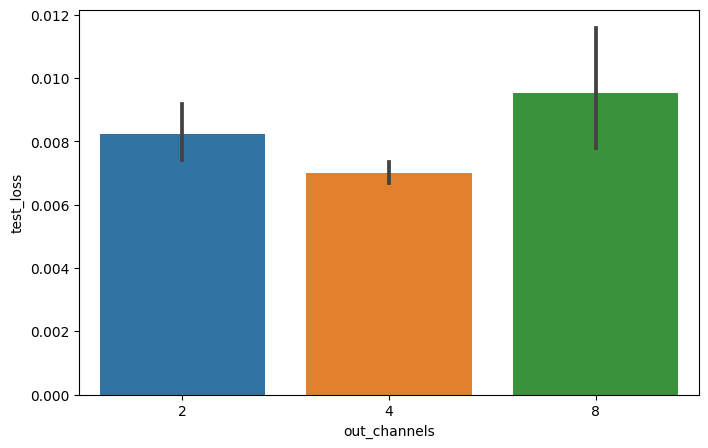

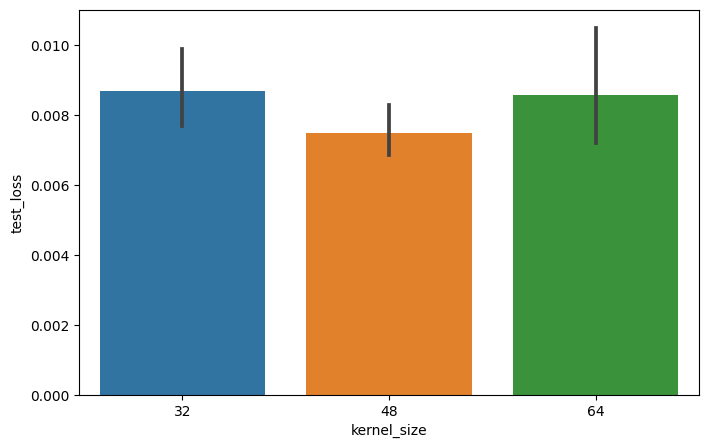

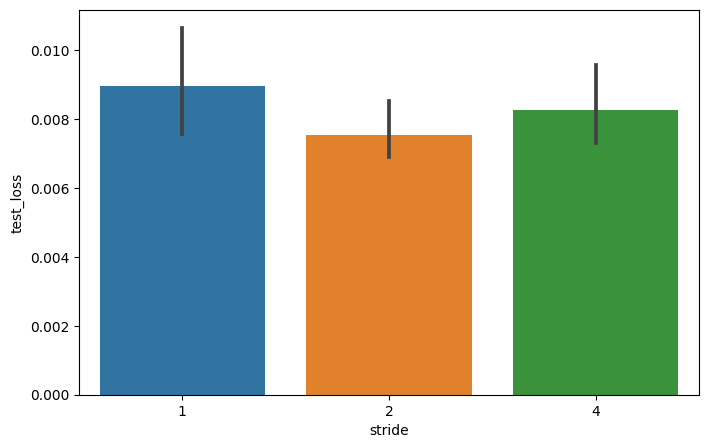

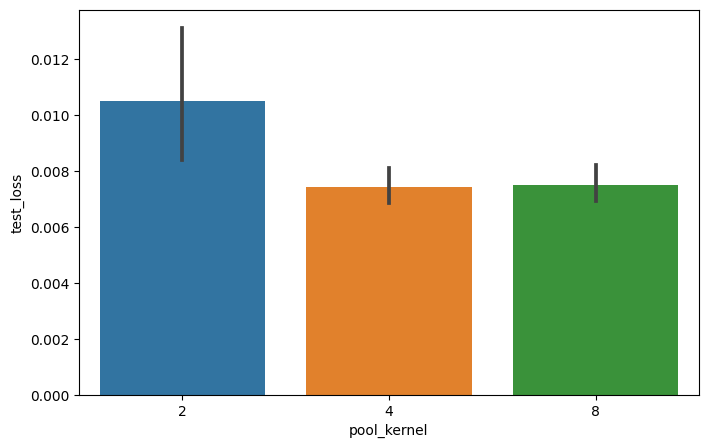

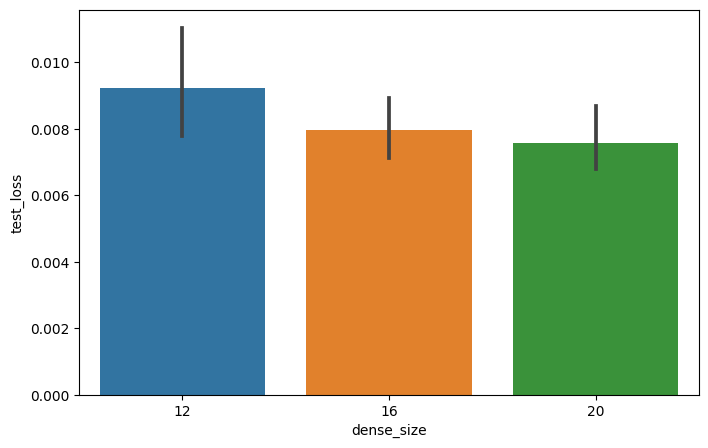

In [14]:
for col in ['out_channels','kernel_size','stride','pool_kernel','dense_size']:
    plt.figure(figsize=(8,5))
    sns.barplot(data=grid_df, x=col, y='test_loss')
    plt.show()

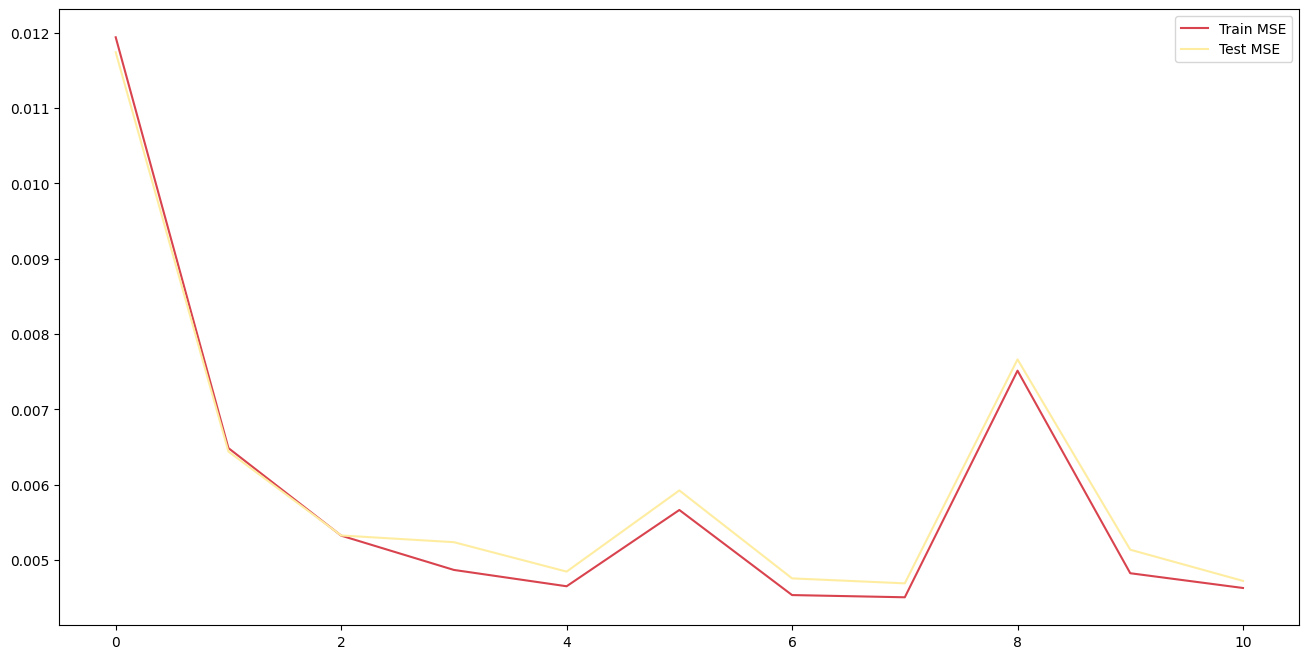

In [15]:
best_out_channels, best_kernel_size, best_stride, best_pool_kernel = grid_df.iloc[grid_df['test_loss'].argmin(),:4].to_numpy(dtype=np.int32)

# display(best_out_channels, best_kernel_size, best_stride, best_pool_kernel)
model = SineCNN(
    train_dataset.shape[2] - 1,
    out_channels=best_out_channels,
    kernel_size=best_kernel_size,
    stride=best_stride,
    pool_kernel=best_pool_kernel,
).double()

model, items = train(model, train_dataset, test_dataset, n_epochs=100, test_full=True, early_stop_patience=30) 
plot_loss(
    items,
    title=''
)
torch.save(model, 'best_model.pt')